In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
const.BETA4

32.70989286766126

In [3]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [4]:
class ConvergedResult:
    def __init__(self, f, n, a0):
        self.f = f
        self.n = n
        self.a0 = a0

In [5]:
results = []

In [7]:
R_mm = 1.5
nq = 520
f = 20
qmax = f*2/R_mm
qmesh = utility.log_mesh(0, qmax, nq)

mm = LocalSystem(1.5, qmesh=(*qmesh, qmax))
vtilde_mm = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)

kcd_0_mm = mu2.cc.cscatter.kcotdelta_py(0, vtilde_mm, mm.q, mm.wq, mm.q_max, 0, 2*const.MU)

In [8]:
KCD_0_MM = kcd_0_mm

In [9]:
Rs = const.BETA4/np.linspace(40, 80, 50)

In [10]:
Ri = Rs[0]
f = 20
qmax = f*2/Ri
nq = 520
qmesh = utility.log_mesh(0, qmax, nq)
ls = LocalSystem(Ri, qmesh=(*qmesh, qmax))

In [19]:
def kcd0(g, ls):
    return mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(guess, 0), ls.q, ls.wq, ls.q_max, 0, 2*const.MU
    )

In [20]:
rgf_large_R = np.loadtxt('rgflow_local_lo_a0_fix_hp.txt')

In [21]:
guess = rgf_large_R[-1, 1]
kcd0(guess, ls), ls.bound_state_spectrum(guess, 0).size

(0.016376060105340585, 7)

In [23]:
def froot(g, ls, qmax):
    spectrum = ls.bound_state_spectrum(g, 0)
    assert spectrum.size == 7, f'There are {spectrum.size} bounds states.'
    return (KCD_0_MM - mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)) / KCD_0_MM

In [24]:
froot(guess, ls, qmax)

1.2980391082273922e-05

In [25]:
class Data:
    def __init__(self, ls, g_lo, qmax):
        self.a0 = -1/mu2.cc.cscatter.kcotdelta_py(
            0, ls.v_tilde + ls.counterterm.gen(g_lo, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g_lo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.g_lo = g_lo

In [27]:
glos = np.zeros(Rs.size)
data = []

for (i, Ri) in enumerate(Rs):
    qmax = f*2/Ri
    qmesh = utility.log_mesh(0, qmax, nq)
    ls = LocalSystem(Ri, qmesh=(*qmesh, qmax))
    result = optimize.fsolve(froot, guess, args=(ls, qmax), xtol=1e-12)
    glo = result[0]
    
    glos[i] = glo
    data.append(Data(ls, glo, qmax))
    
    if i < 5:
        guess = 1.5*glo
    else:
        curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = curve(Rs[i+1])
        except:
            break
    
    print(f'i = {i}  R = {Ri:.4e}  g_LO = {glo:.4e}')

i = 0  R = 8.1775e-01  g_LO = 4.5584e+02
i = 1  R = 8.0139e-01  g_LO = 9.2609e+02
i = 2  R = 7.8568e-01  g_LO = 1.9500e+03
i = 3  R = 7.7057e-01  g_LO = 4.2616e+03


AssertionError: There are 8 bounds states.

In [45]:
len(data)

50

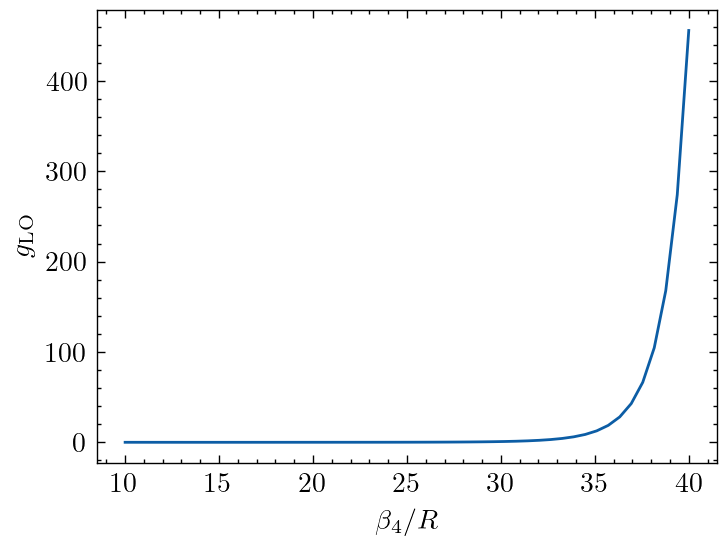

In [36]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs, glos)

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

In [37]:
lo_specs = np.array([d.lo_evals for d in data])

In [38]:
-1/KCD_0_MM - np.array([d.a0 for d in data])

array([ 0.00000000e+00,  7.10542736e-14,  4.83169060e-13,  7.81597009e-14,
       -8.52651283e-14,  1.35003120e-13,  1.56319402e-13,  4.40536496e-13,
       -3.05533376e-13, -2.13162821e-14,  0.00000000e+00, -2.13162821e-14,
        5.68434189e-14,  5.68434189e-14,  3.90798505e-13,  2.13162821e-13,
        1.06581410e-13,  5.68434189e-14,  2.20268248e-13,  3.55271368e-13,
        2.34479103e-13, -1.13686838e-13, -1.27897692e-13, -3.55271368e-14,
        7.10542736e-14,  0.00000000e+00, -7.10542736e-13, -1.37134748e-12,
        1.70530257e-13,  1.70530257e-13,  1.56319402e-13, -6.03961325e-13,
        9.37916411e-13,  6.75015599e-13, -1.23634436e-12, -1.29318778e-12,
       -1.10844667e-12,  1.42819090e-12,  3.55271368e-13, -2.13162821e-14,
        2.75690581e-12,  1.20792265e-12, -3.15480975e-12, -9.94759830e-14,
       -1.14042109e-11, -2.04636308e-11,  6.28830321e-12, -2.45137244e-12,
        4.32720526e-12, -2.73487899e-11])

In [39]:
mm_evals, mm_evecs = bind.bound_states(vtilde_mm, 0, 0, mm.q, mm.wq)
mm_evals

array([-0.06476099, -0.04422775, -0.02740749, -0.01466227, -0.00611664,
       -0.00156343, -0.00012025])

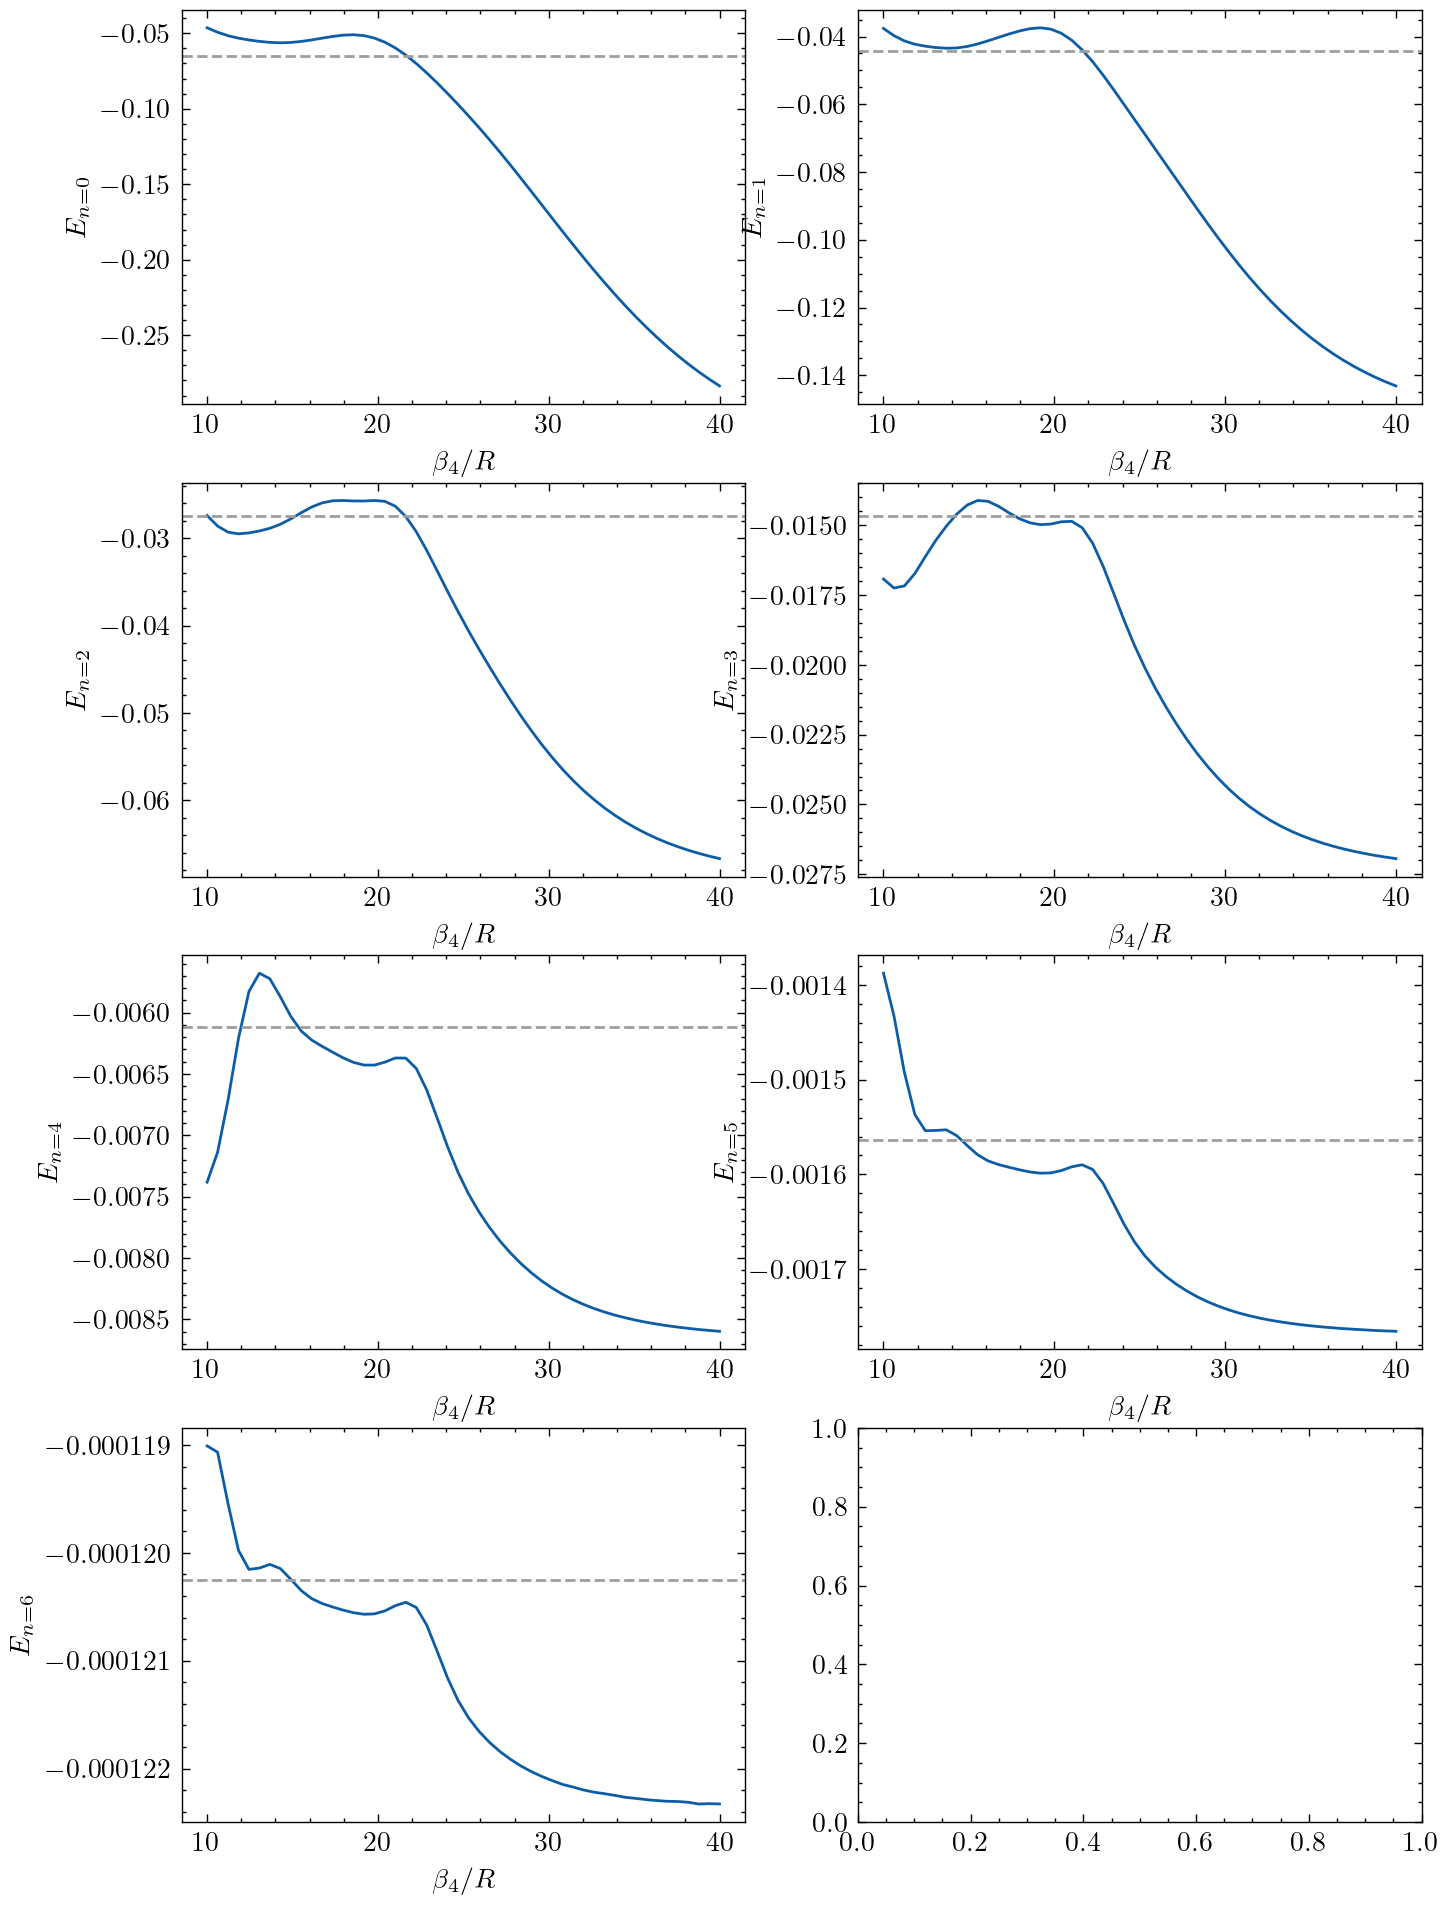

In [40]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, lo_specs[:, i])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

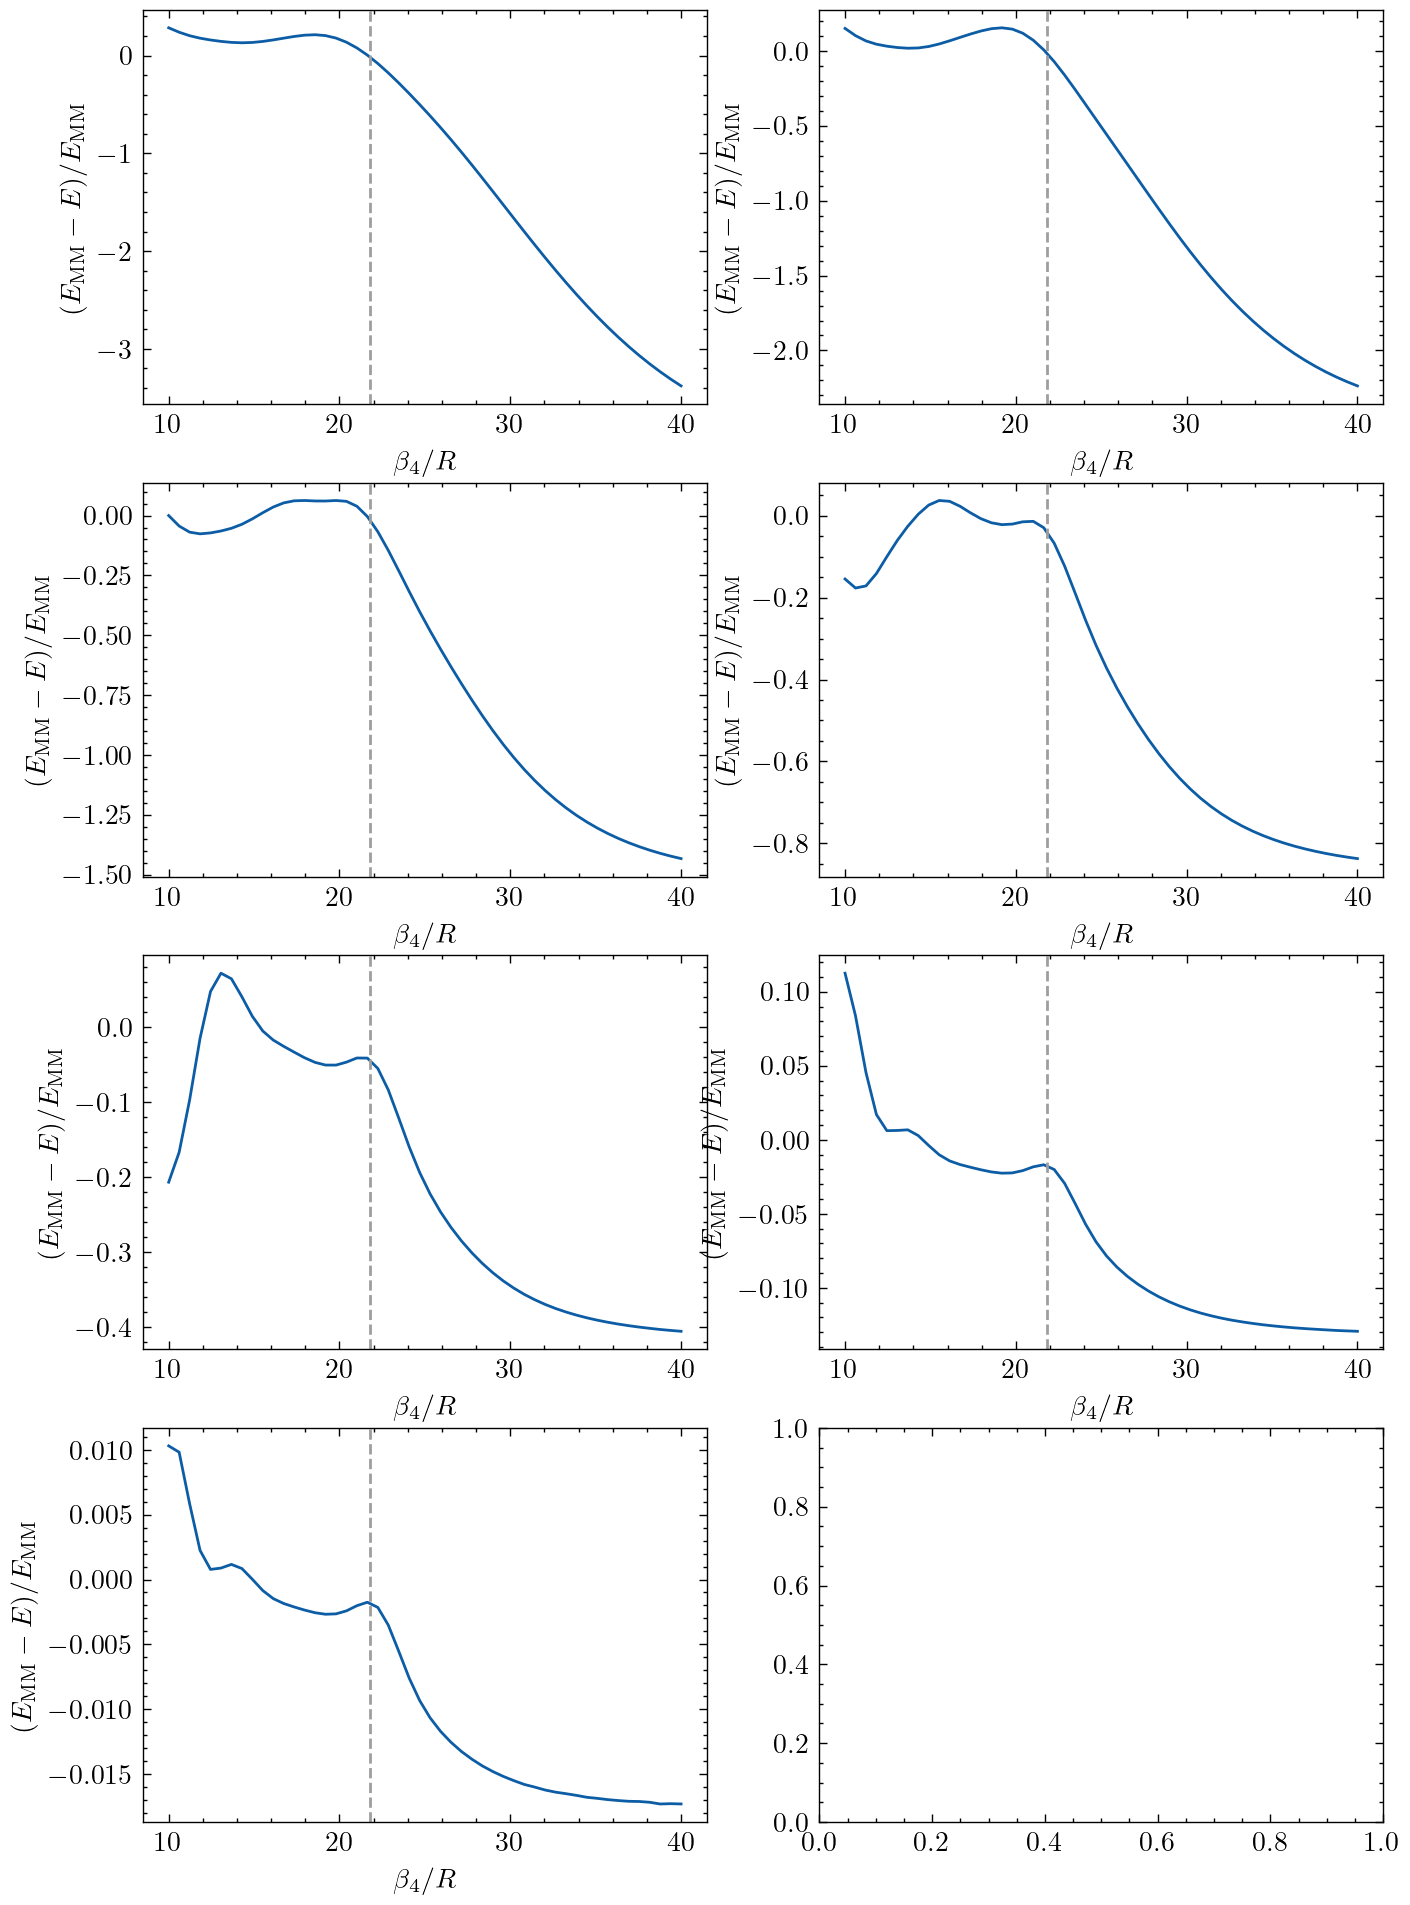

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

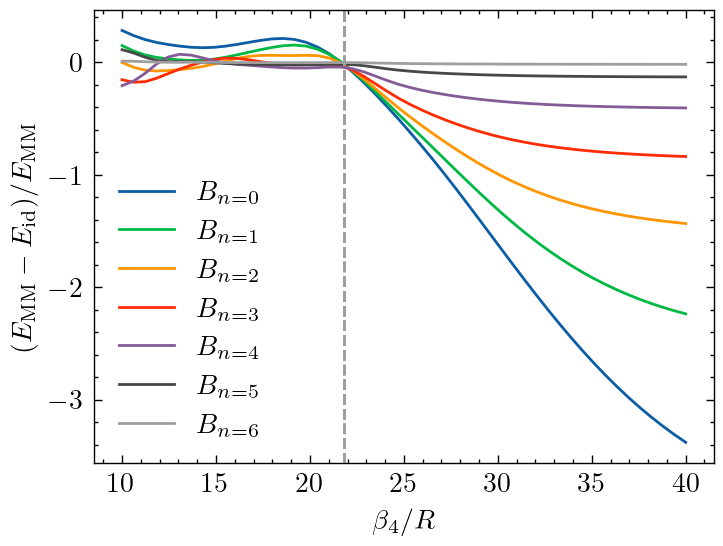

In [42]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i], label='$B_{n=%d}$' % (i))
    ax.set_xlabel(r'$\beta_4/R$')
    ax.set_ylabel(r'$(E_{\rm MM}-E_{\rm id})/E_{\rm MM}$')
    ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')
ax.legend();

In [43]:
np.savetxt('rgflow_local_lo_a0_fix_hp.txt', np.vstack((Rs, glos)).T, header='R  g_LO')

In [44]:
np.savetxt('spectra_local_lo_a0_fix_hp.txt', np.vstack((Rs, lo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')